<a href="https://colab.research.google.com/github/menaman123/Robust-Machine-Learning-Against-Poisoning-Attacks/blob/main/ensemble_learning_mitigation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision import datasets, transforms
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from itertools import combinations

Dataset Prep & Poisoning

In [ ]:
class PoisonedDataset(Dataset):
    def __init__(self, base_dataset, poison_ratio=0.3):
        self.base_dataset = base_dataset
        self.poison_ratio = poison_ratio
        self.poisoned_indices = self._generate_poisoned_indices()

    def _generate_poisoned_indices(self):
        num_samples = len(self.base_dataset)
        poison_size = int(num_samples * self.poison_ratio)
        indices = np.random.choice(num_samples, poison_size, replace=False)
        return indices

    def __getitem__(self, idx):
        img, label = self.base_dataset[idx]
        if idx in self.poisoned_indices:
            # Example: Flip label for poisoning
            label = (label + 1) % 10  # MNIST has 10 classes
        return img, label

    def __len__(self):
        return len(self.base_dataset)

Load dataset and apply poisoning

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
poisoned_dataset = PoisonedDataset(train_dataset, poison_ratio=0.3)

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 500kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.62MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.3MB/s]


Distributed Training and Model Setup

In [ ]:
def setup(rank, world_size):
    # Initialize distributed training
    dist.init_process_group("nccl", rank=rank, world_size=world_size)

def cleanup():
    dist.destroy_process_group()

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 13 * 13, 10)  # Adjust based on input size

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = x.view(-1, 32 * 13 * 13)
        x = self.fc1(x)
        return x

In [ ]:
class MNIST_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 13 * 13, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = x.view(-1, 32 * 13 * 13)
        return self.fc1(x)

class CIFAR10_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(64 * 6 * 6, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 6 * 6)
        return self.fc1(x)

Disagreement Calculation & Pruning

In [ ]:
def compute_model_disagreement(models, dataloader, device):
    total_disagreements = []
    for data, _ in dataloader:
        data = data.to(device)
        preds = [model(data).argmax(dim=1) for model in models]
        disagreement = sum([(p1 != p2).sum().item()
                          for p1, p2 in combinations(preds, 2)])
        total_disagreements.append(disagreement)
    return np.mean(total_disagreements)

# Prune the most disagreeing model
def prune_weights(layer, prune_ratio=0.1):
    # Prune top `prune_ratio`% of weights with highest magnitude
    weights = layer.weight.data
    threshold = np.percentile(np.abs(weights.cpu().numpy()), 100 - (prune_ratio * 100))
    mask = np.abs(weights.cpu().numpy()) <= threshold  # Corrected condition
    layer.weight.data *= torch.tensor(mask, dtype=torch.float32).to(weights.device)

Training Loop with Pruning

In [ ]:
def train(rank, world_size):
    if torch.cuda.is_available():
        # Initialize the process group
        dist.init_process_group("nccl", rank=rank, world_size=world_size)
        device = torch.device(f'cuda:{rank}')
    else:
        device = torch.device('cpu')

    setup(rank, world_size)

    # Split dataset into 4 subsets
    subset_indices = np.array_split(np.arange(len(poisoned_dataset)), world_size)
    train_subset = Subset(poisoned_dataset, subset_indices[rank])
    train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)

    # Initialize model and optimizer
    model = SimpleCNN().to(rank)
    model = DDP(model, device_ids=[rank])
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    # Attach activation extractor to the first convolutional layer
    extractor = ActivationExtractor(model.module)
    extractor.hook_layer('conv1')

    for epoch in range(10):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(rank), target.to(rank)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

        # After each epoch, compute disagreement and prune
        if rank == 0:  # Only master process handles pruning
            all_activations = []
            for r in range(world_size):
                # Gather activations from all GPUs (simplified example)
                activations = extractor.activations['conv1']
                all_activations.append(activations)

            disagreement = compute_model_disagreement(all_activations)
            if disagreement > 0.5:  # Threshold for pruning
                prune_weights(model.module.conv1, prune_ratio=0.1)

    cleanup()

Model Combination (Inference)

In [ ]:
def combine_predictions(models, dataloader):
    all_preds = []
    for model in models:
        model.eval()
        preds = []
        with torch.no_grad():
            for data, _ in dataloader:
                data = data.to(device)
                output = model(data)
                preds.append(output.argmax(dim=1))
        all_preds.append(torch.cat(preds))

    # Majority voting
    final_preds = torch.mode(torch.stack(all_preds), dim=0).values
    return final_preds

In [ ]:
def combine_predictions2(models, dataloader, device):
    all_preds = []
    for model in models:
        model.eval()
        preds = []
        with torch.no_grad():
            for data, _ in dataloader:
                data = data.to(device)
                output = model(data)
                preds.append(output.argmax(dim=1))
        all_preds.append(torch.cat(preds))

    # Majority voting
    stacked_preds = torch.stack(all_preds)
    final_preds = torch.mode(stacked_preds, dim=0).values
    return final_preds

In [ ]:
def evaluate_model(model, dataloader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    return correct / total * 100

In [ ]:
def ensemble_predict(models, dataloader, device):
    all_preds = []
    for model in models:
        model.eval()
        preds = []
        with torch.no_grad():
            for data, _ in dataloader:
                data = data.to(device)
                output = model(data)
                preds.append(output.argmax(dim=1))
        all_preds.append(torch.cat(preds))
    return torch.mode(torch.stack(all_preds), dim=0).values

In [ ]:
# Experiment runner
def run_experiment(dataset_name, poisoned, pruning, num_models=4, epochs=5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"\nRunning experiment: {dataset_name} | Poisoned: {poisoned} | Pruning: {pruning}")

    # Dataset configuration
    transform = transforms.Compose([transforms.ToTensor()])
    if dataset_name == 'MNIST':
        train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
        model_class = MNIST_CNN
    else:
        train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
        model_class = CIFAR10_CNN

    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform) if dataset_name == 'MNIST' else \
                   datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    # Create poisoned or clean dataset
    train_data = PoisonedDataset(train_dataset) if poisoned else train_dataset
    test_loader = DataLoader(test_dataset, batch_size=256)

    # Train models
    models = []
    accuracies = []
    subset_indices = np.array_split(np.arange(len(train_data)), num_models)

    for i in range(num_models):
        model = model_class().to(device)
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)

        optimizer = optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.CrossEntropyLoss()
        train_loader = DataLoader(Subset(train_data, subset_indices[i]), batch_size=64, shuffle=True)

        for epoch in range(epochs):
            model.train()
            for data, target in train_loader:
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                outputs = model(data)
                loss = criterion(outputs, target)
                loss.backward()
                optimizer.step()

        acc = evaluate_model(model, test_loader, device)
        models.append(model)
        accuracies.append(acc)
        print(f"Model {i+1} accuracy: {acc:.2f}%")

    # Prune if enabled
    if pruning:
        prune_idx = np.argmin(accuracies)
        models = [model for i, model in enumerate(models) if i != prune_idx]
        print(f"Pruned model {prune_idx+1} with accuracy {accuracies[prune_idx]:.2f}%")

    # Ensemble accuracy
    all_preds = []
    for model in models:
        model.eval()
        preds = []
        with torch.no_grad():
            for data, _ in test_loader:
                data = data.to(device)
                outputs = model(data)
                preds.append(outputs.argmax(dim=1))
        all_preds.append(torch.cat(preds))

    final_preds = torch.mode(torch.stack(all_preds), dim=0).values
    y_true = torch.cat([target for _, target in test_loader]).to(device)
    ensemble_acc = (final_preds == y_true).float().mean().item() * 100
    return ensemble_acc

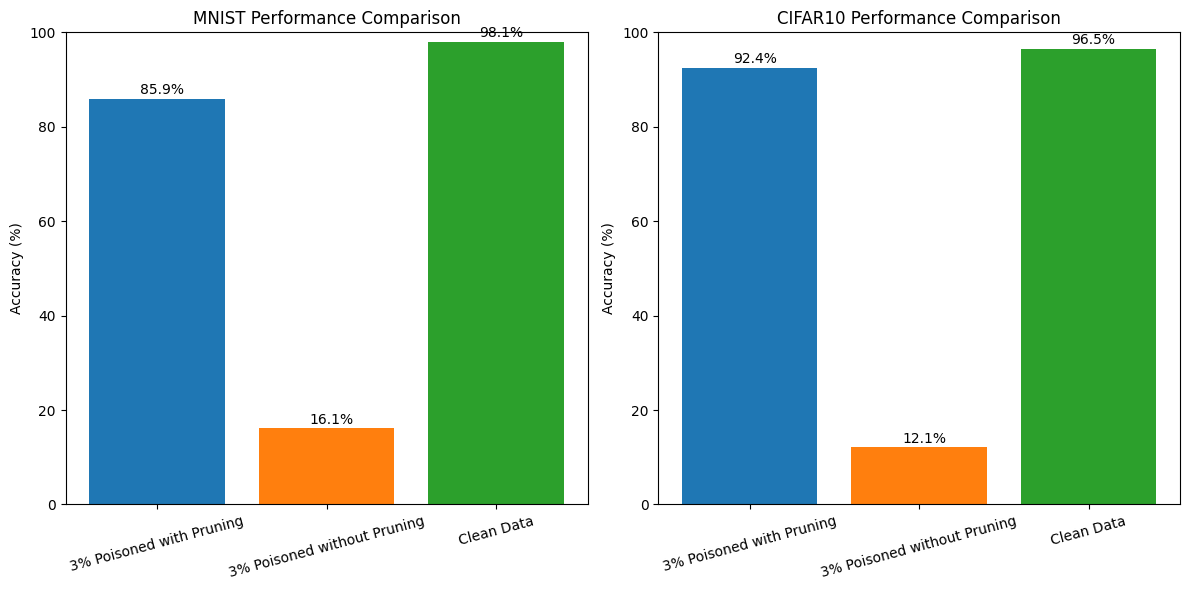

In [ ]:
import matplotlib.pyplot as plt
# Run all experiments

results = {}

dataset_names = ['MNIST', 'CIFAR10'] # Changed variable name

conditions = [
 ('3% Poisoned with Pruning', True, True),

('3% Poisoned without Pruning', True, False),

('Clean Data', False, False)

]



for dataset in dataset_names: # Use renamed variable
  results[dataset] = {}
  for cond_name, poisoned, pruning in conditions:
    acc = run_experiment(dataset, poisoned, pruning)
    results[dataset][cond_name] = acc



# Plot results

plt.figure(figsize=(12, 6))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for idx, dataset in enumerate(dataset_names): # CORRECTED LINE

  plt.subplot(1, 2, idx+1)
  values = [results[dataset][cond] for cond, _, _ in conditions]
  plt.bar([cond[0] for cond in conditions], values, color=colors)
  plt.title(f'{dataset} Performance Comparison')
  plt.ylabel('Accuracy (%)')
  plt.ylim(0, 100)
  plt.xticks(rotation=15)
  for i, v in enumerate(values):
    plt.text(i-0.1, v+1, f"{v:.1f}%")



plt.tight_layout()

plt.show()

Execution Script